   #  Facial Key point Detection  #

**Introduction**  

This project is for predicting keypoint positions on face images. This can be used as a building block in several applications, such as:  

Tracking faces in images and video  
Analysing facial expressions  
Detecting dysmorphic facial signs for medical diagnosis  
Biometrics / face recognition
etc.

Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.  


**Data Description**  
Data is taken from Kaggle: https://www.kaggle.com/c/facial-keypoints-detection/data

Each facial key point is specified by an (x,y) real-valued pair. Dataset consists of 15 keypoints, which represent the following elements of the face:

1.  left_eye_center
2.  right_eye_center
3.  left_eye_inner_corner
4.  left_eye_outer_corner
5.  right_eye_inner_corner
6.  right_eye_outer_corner
7.  left_eyebrow_inner_end
8.  left_eyebrow_outer_end
9.  right_eyebrow_inner_end
10. right_eyebrow_outer_end
11. nose_tip, mouth_left_corner
12. mouth_right_corner
13. mouth_center_top_lip
14. mouth_center_bottom_lip

And the 15th field is the input image.

Training data consists of total 7,049 96x96 gray-scale images. But in most examples, few of the target keypoint positions are misssing. Here for our project we will only use the examples having all 15 data points. Count for those ddata is 2140.
Left and right here refer to the point of view of the subject.

There are separate dataset for training and test. These two datasets differ in that the test data doesn't contain the target values; it's the goal of the challenge to predict these.

**Objective** : 

As this is a regression problem, by default objective function is mean squared error (MSE)
Therefore, **our goal here is to build the net with minimum loss function (Root Mean Square Error) and finally predict the test images and point out the facial key elements in the predicted images**.  

Here we will be building the solution step by step using Lasagne with Python and Theano.
I will first try to train the net nicely without much attention on overfitting problem. Once the net is nicely trained, will try to regularize.
First will start with a couple layers of Neural Network architectures.
As our goal is to have minimum Root Mean Square Error from our training, will try to introduce augmentation and dropout concept to get better result.

**Pre-requisites**

Neural networks — with more than one hidden layer — require a dumptruck load of data to become effective predictive engines. These models require powerful computing nodes and big RAM stores, and loads of data need ample storage and caching capabilities.

So to use Neural Net for our project, pre-requisites are:

1. To use GPU (either on computer or on AWS)
2. To configure GPU to run Theano

In [96]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import os
import numpy as np
import sys
import cPickle as pickle
from numpy import array
from numpy import reshape
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.metrics import mean_squared_error
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#from sklearn.linear_model import LinearRegression
#from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import Binarizer
from sklearn import metrics
#from sklearn.naive_bayes import MultinomialNB
#from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle
from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics import classification_report

###
import lasagne
import theano
import nolearn
#from theano.tensor.signal.pool import pool_2d
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
###
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [97]:
# Create two data set for training and test: FTRAIN, FTEST

FTRAIN = '~/Documents/GraduateStudy/MIDS/W207/Projects/Final/icandoit/Data/Kaddle-featureSelection/training.csv'
FTEST = '~/Documents/GraduateStudy/MIDS/W207/Projects/Final/icandoit/Data/Kaddle-featureSelection/test.csv'


In [98]:
# Define a function that can load both the training and the test data from the CSV files provided.

def load_data(test=False, cols=None):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if work involves only a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; 
    # convert the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


def load2d(test=False, cols=None):
    '''
    This function wraps the previously written load
    and does the necessary transformations
    '''
    X, y = load_data(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

First let's print the list of all columns in the CSV file along with the number of available values for each. load_data() returns a tuple (X, y) where y is the target matrix. y has shape n x m with n being the number of samples in the dataset that have all m keypoints. Dropping all rows with missing values is what this line does:  
df = df.dropna()  # drop all rows that have missing values in them

In [99]:
# Call load_data function to load Training Data

X, y = load_data()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

The script's output y.shape == (2140, 30) tells us that there's only 2,140 images in the dataset that have all 30 target values present. Here we will be building our project based on these 2140 data.  

Another feature of the load() function is that it scales the intensity values of the image pixels to be in the interval [0, 1], instead of 0 to 255. The target values (x and y coordinates) are scaled to [-1, 1]; before they were between 0 to 95.

**First Model: a single hidden layer Neural Net**  

Here along with input and output layer, one hidden layer is being used.  
The parameter 'layers' specifies the type of each layer, and their order.  
'input_shape', 'hidden_num_units', 'output_nonlinearity', and 'output_num_units' are each parameters for specific layers; they refer to the layer by their prefix.

The first dimension of input_shape is None so that it can get translated to a variable batch size.

output_nonlinearity is explicitly set to None so that the output units' activations become just a linear combination of the activations in the hidden layer.

The default nonlinearity used by DenseLayer is the rectifier, which is simply max(0, x). By not explicitly setting hidden_nonlinearity, we're choosing the rectifier as the activiation function of our hidden layer.

The neural net's weights are initialized by Lasagne by using "Glorot-style" initialization. The idea behind Glorot Initializatio is to initialize each weight with a small Gaussian value with mean = 0.0 and variance based on the fan-in and fan-out of the weight.
And nesterov_momentum function is being used for gradient descent optimization.  

There are few more parameters. All parameters starting with update parametrize the update function, or optimization method. The update function will update the weights of the network after each batch.

An epoch is a measure of the number of times all of the training vectors are used once to update the weights. For batch training all of the training samples pass through the learning algorithm simultaneously in one epoch before weights are updated.  

The last set of parameters declares that we're dealing with a regression problem (as opposed to classification), that 400 is the number of epochs to be trained, and that we want to print out information during training by setting verbose=1

In [103]:
# build the single hidden layered neural net: net1

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01, # This measures the gradient descent update steps.
    update_momentum=0.9, # Using the default value

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    # For our regression problem we will be using default objective function MSE to minimize
    verbose=1,
    )

# Call load function to load train data

X, y = load_data()

# Fit Train data on net1

net1.fit(X, y)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

    102     0.00474     0.00513    0.92392  0.32s
    103     0.00472     0.00512    0.92310  0.32s
    104     0.00470     0.00510    0.92237  0.33s
    105     0.00469     0.00508    0.92158  0.33s
    106     0.00467     0.00507    0.92088  0.32s
    107     0.00465     0.00505    0.92015  0.33s
    108     0.00463     0.00504    0.91946  0.38s
    109     0.00461     0.00502    0.91858  0.37s
    110     0.00460     0.00501    0.91794  0.37s
    111     0.00458     0.00499    0.91719  0.33s
    112     0.00456     0.00498    0.91658  0.33s
    113     0.00455     0.00496    0.91583  0.33s
    114     0.00453     0.00495    0.91514  0.32s
    115     0.00451     0.00494    0.91447  0.37s
    116     0.00450     0.00492    0.91378  0.32s
    117     0.00448     0.00491    0.91311  0.32s
    118     0.00447     0.00489    0.91244  0.32s
    119     0.00445     0.00488    0.91179  0.32s
    120     0.00443     0.00487    0.91115  0.32s
    121     0.00442     0.00485    0.91052  0.32s


    223     0.00339     0.00395    0.85896  0.33s
    224     0.00338     0.00394    0.85848  0.32s
    225     0.00338     0.00393    0.85804  0.33s
    226     0.00337     0.00393    0.85766  0.33s
    227     0.00336     0.00392    0.85720  0.33s
    228     0.00336     0.00392    0.85680  0.32s
    229     0.00335     0.00391    0.85634  0.33s
    230     0.00334     0.00391    0.85594  0.33s
    231     0.00334     0.00390    0.85552  0.32s
    232     0.00333     0.00390    0.85509  0.32s
    233     0.00332     0.00389    0.85468  0.32s
    234     0.00332     0.00388    0.85427  0.32s
    235     0.00331     0.00388    0.85385  0.32s
    236     0.00331     0.00387    0.85340  0.32s
    237     0.00330     0.00387    0.85294  0.33s
    238     0.00329     0.00386    0.85249  0.32s
    239     0.00329     0.00386    0.85208  0.33s
    240     0.00328     0.00385    0.85169  0.33s
    241     0.00327     0.00385    0.85125  0.33s
    242     0.00327     0.00384    0.85085  0.33s


    344     0.00278     0.00343    0.80882  0.32s
    345     0.00277     0.00343    0.80841  0.32s
    346     0.00277     0.00343    0.80795  0.32s
    347     0.00277     0.00343    0.80752  0.32s
    348     0.00276     0.00342    0.80719  0.32s
    349     0.00276     0.00342    0.80676  0.32s
    350     0.00275     0.00342    0.80633  0.32s
    351     0.00275     0.00341    0.80595  0.33s
    352     0.00275     0.00341    0.80547  0.32s
    353     0.00274     0.00341    0.80509  0.33s
    354     0.00274     0.00340    0.80467  0.32s
    355     0.00274     0.00340    0.80436  0.32s
    356     0.00273     0.00340    0.80383  0.33s
    357     0.00273     0.00340    0.80341  0.32s
    358     0.00272     0.00339    0.80298  0.33s
    359     0.00272     0.00339    0.80262  0.32s
    360     0.00272     0.00339    0.80215  0.33s
    361     0.00271     0.00339    0.80161  0.34s
    362     0.00271     0.00338    0.80122  0.33s
    363     0.00271     0.00338    0.80088  0.33s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x120457150>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x12044afd0>,
     check_input=True, custom_scores=None, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x12044e500>,
     objective_loss_function=<function squared_error at 0x1204020c8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x12a463c68>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x12a463c20>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     scores_train=[], scores_valid=[],
     train

Running these two lines will output a table that grows one row per training epoch. In each row, we'll see the current loss (Mean Square Error) on the train set and on the validation set and the ratio between the two. NeuralNet automatically splits the data provided in X into a training and a validation set, using 20% of the samples for validation. (this ratio can be adjusted by overriding the eval_size=0.2 parameter.)

The target coordinates were earier divided by 48 to scale in the interval [-1, 1]. Thus, to calculate the root-mean-square error, as that's what's used as the project goal, based on our MSE loss of 0.00329, we'll take the square root and multiply by 48 again:

In [101]:
print "Validation Loss for net1 = ", 0.00329
print "RMSE for net1 = ", np.sqrt(0.00329) * 48

Validation Loss for net1 =  0.00329
RMSE for net1 =  2.75320903674


The net1 object actually keeps a record of the data that it prints out in the table. We can access that record through the train_history_ attribute. Let's draw those two curves to have a clear picture on training loss and validation loss:

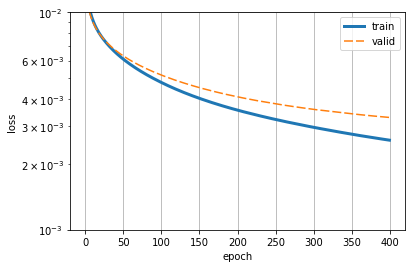

In [104]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, dashes=[6, 2], label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")
plt.show()

The plot clearly shows that net1 overfits; but it's not that bad. In particular, the validation error never gets worse again.
Point to notice: No use of any regularization at this moment.

Now will try using Convolution Neural Network.
Convolutional layers are little different to fully connected layers in a way that it can reduce the number of parameters to be learned, while retaining high expressiveness.
These are:
Local Connectivity: Neurons are connected only to a subset of neurons in the previous layer,
Weight Sharing: weights are shared between a subset of neurons in the convolutional layer
Pooling: Static subsampling of inputs.

When using convolutional layers in Lasagne, the input data can no longer be a flat vector of 9,216 pixel intensities, but a three-dimensional matrix with shape (c, x, y), where c is the number of channels (colors), and x and y correspond to the x and y dimensions of the input image. In this case, the shape will be (1, 96, 96), because we'll be considering a single (gray) color channel only.

**Second Model using Convolution Neural Net: net2**  

We'll build a convolutional neural net with three convolutional layers and two fully connected layers. Each conv layer is followed by a 2x2 max-pooling layer. Starting with 32 filters, we double the number of filters with every conv layer. The densely connected hidden layers both have 500 units.  
There is again no regularization in the form of weight decay or dropout. It turns out that using very small convolutional filters, such as our 3x3 and 2x2 filters, is again a pretty good regularizer by itself.
  
Will try write down the code:

In [12]:
# Build convolution neural net with three convolutional layers and two fully connected layers: net2

net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=1000,
    verbose=1,
    )

# Here we are calling load2d function which transforms our flat 96X96 data
# to 3d shape of (1,96,96), which is needed for convolution neural net.

X, y = load2d()  # load 2-d data

# Train model net2
net2.fit(X, y)

# pickle the trained model so that it can be loaded later

import cPickle as pickle
with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

     98     0.00422     0.00401    1.05194  27.53s
     99     0.00421     0.00400    1.05188  27.65s
    100     0.00421     0.00400    1.05182  27.54s
    101     0.00420     0.00400    1.05173  27.51s
    102     0.00420     0.00399    1.05165  27.46s
    103     0.00420     0.00399    1.05157  27.50s
    104     0.00419     0.00399    1.05149  27.65s
    105     0.00419     0.00398    1.05141  27.46s
    106     0.00418     0.00398    1.05132  27.43s
    107     0.00418     0.00398    1.05124  27.53s
    108     0.00418     0.00397    1.05115  27.75s
    109     0.00417     0.00397    1.05110  27.52s
    110     0.00417     0.00397    1.05102  27.55s
    111     0.00416     0.00396    1.05096  27.37s
    112     0.00416     0.00396    1.05087  27.63s
    113     0.00415     0.00395    1.05083  27.70s
    114     0.00415     0.00395    1.05076  27.60s
    115     0.00415     0.00395    1.05068  27.62s
    116     0.00414     0.00394    1.05062  27.59s
    117     0.00414     0.00394

    217     0.00356     0.00345    1.03396  27.72s
    218     0.00356     0.00344    1.03364  27.53s
    219     0.00355     0.00343    1.03335  27.54s
    220     0.00354     0.00343    1.03304  27.58s
    221     0.00354     0.00342    1.03274  27.71s
    222     0.00353     0.00342    1.03241  27.54s
    223     0.00352     0.00341    1.03206  27.55s
    224     0.00351     0.00341    1.03174  27.61s
    225     0.00351     0.00340    1.03137  27.74s
    226     0.00350     0.00340    1.03102  27.60s
    227     0.00349     0.00339    1.03068  28.90s
    228     0.00349     0.00338    1.03033  27.61s
    229     0.00348     0.00338    1.03005  27.47s
    230     0.00347     0.00337    1.02969  27.72s
    231     0.00347     0.00337    1.02935  27.60s
    232     0.00346     0.00336    1.02902  27.56s
    233     0.00345     0.00335    1.02864  27.46s
    234     0.00344     0.00335    1.02833  27.65s
    235     0.00344     0.00334    1.02800  27.50s
    236     0.00343     0.00334

    336     0.00269     0.00275    0.97772  27.63s
    337     0.00269     0.00275    0.97714  27.50s
    338     0.00268     0.00274    0.97667  27.70s
    339     0.00267     0.00274    0.97606  27.57s
    340     0.00266     0.00273    0.97560  27.62s
    341     0.00266     0.00273    0.97501  27.61s
    342     0.00265     0.00272    0.97452  27.68s
    343     0.00265     0.00272    0.97394  27.59s
    344     0.00264     0.00271    0.97346  27.63s
    345     0.00263     0.00271    0.97292  27.50s
    346     0.00263     0.00270    0.97249  27.71s
    347     0.00262     0.00269    0.97196  27.57s
    348     0.00261     0.00269    0.97148  27.57s
    349     0.00261     0.00268    0.97098  27.58s
    350     0.00260     0.00268    0.97044  27.46s
    351     0.00259     0.00267    0.96996  27.75s
    352     0.00259     0.00267    0.96948  27.52s
    353     0.00258     0.00266    0.96897  27.46s
    354     0.00257     0.00266    0.96846  27.56s
    355     0.00257     0.00265

    455     0.00208     0.00225    0.92625  27.68s
    456     0.00208     0.00224    0.92593  27.70s
    457     0.00207     0.00224    0.92551  27.63s
    458     0.00207     0.00224    0.92514  27.63s
    459     0.00207     0.00223    0.92475  27.57s
    460     0.00206     0.00223    0.92442  27.65s
    461     0.00206     0.00223    0.92405  27.60s
    462     0.00205     0.00222    0.92367  27.62s
    463     0.00205     0.00222    0.92333  27.67s
    464     0.00205     0.00222    0.92292  27.55s
    465     0.00204     0.00221    0.92254  27.66s
    466     0.00204     0.00221    0.92220  27.70s
    467     0.00204     0.00221    0.92177  27.69s
    468     0.00203     0.00221    0.92136  27.67s
    469     0.00203     0.00220    0.92103  27.62s
    470     0.00203     0.00220    0.92062  27.66s
    471     0.00202     0.00220    0.92026  27.49s
    472     0.00202     0.00219    0.91985  27.79s
    473     0.00202     0.00219    0.91955  27.57s
    474     0.00201     0.00219

    574     0.00174     0.00197    0.88190  30.79s
    575     0.00174     0.00197    0.88161  27.05s
    576     0.00173     0.00197    0.88117  26.84s
    577     0.00173     0.00197    0.88088  34.29s
    578     0.00173     0.00197    0.88049  29.09s
    579     0.00173     0.00196    0.88008  28.31s
    580     0.00173     0.00196    0.87978  27.18s
    581     0.00172     0.00196    0.87939  26.86s
    582     0.00172     0.00196    0.87898  26.85s
    583     0.00172     0.00196    0.87868  26.86s
    584     0.00172     0.00196    0.87825  26.94s
    585     0.00172     0.00195    0.87787  27.20s
    586     0.00171     0.00195    0.87751  30.49s
    587     0.00171     0.00195    0.87711  29.06s
    588     0.00171     0.00195    0.87679  30.36s
    589     0.00171     0.00195    0.87643  30.53s
    590     0.00170     0.00195    0.87603  26.89s
    591     0.00170     0.00194    0.87566  26.80s
    592     0.00170     0.00194    0.87535  26.96s
    593     0.00170     0.00194

    693     0.00152     0.00182    0.83736  27.36s
    694     0.00152     0.00182    0.83705  27.32s
    695     0.00152     0.00182    0.83664  27.35s
    696     0.00152     0.00182    0.83634  27.54s
    697     0.00152     0.00182    0.83591  27.67s
    698     0.00152     0.00182    0.83556  27.28s
    699     0.00152     0.00181    0.83519  27.34s
    700     0.00151     0.00181    0.83484  27.39s
    701     0.00151     0.00181    0.83440  27.51s
    702     0.00151     0.00181    0.83402  27.37s
    703     0.00151     0.00181    0.83359  27.76s
    704     0.00151     0.00181    0.83327  27.40s
    705     0.00151     0.00181    0.83281  27.59s
    706     0.00151     0.00181    0.83249  27.47s
    707     0.00150     0.00181    0.83218  27.29s
    708     0.00150     0.00181    0.83175  27.28s
    709     0.00150     0.00181    0.83143  27.41s
    710     0.00150     0.00180    0.83099  27.36s
    711     0.00150     0.00180    0.83066  27.28s
    712     0.00150     0.00180

    812     0.00137     0.00173    0.79474  27.58s
    813     0.00137     0.00173    0.79430  28.84s
    814     0.00137     0.00173    0.79399  27.36s
    815     0.00137     0.00173    0.79362  27.62s
    816     0.00137     0.00173    0.79323  27.47s
    817     0.00137     0.00173    0.79293  27.64s
    818     0.00137     0.00172    0.79260  27.46s
    819     0.00137     0.00172    0.79220  27.39s
    820     0.00136     0.00172    0.79186  27.47s
    821     0.00136     0.00172    0.79158  27.54s
    822     0.00136     0.00172    0.79119  27.34s
    823     0.00136     0.00172    0.79090  27.31s
    824     0.00136     0.00172    0.79047  27.49s
    825     0.00136     0.00172    0.79020  27.40s
    826     0.00136     0.00172    0.78988  27.29s
    827     0.00136     0.00172    0.78943  27.42s
    828     0.00136     0.00172    0.78913  27.41s
    829     0.00136     0.00172    0.78891  27.43s
    830     0.00135     0.00172    0.78833  27.29s
    831     0.00135     0.00172

    931     0.00126     0.00166    0.75460  27.63s
    932     0.00126     0.00166    0.75429  27.96s
    933     0.00125     0.00166    0.75393  27.62s
    934     0.00125     0.00166    0.75360  27.59s
    935     0.00125     0.00166    0.75325  27.56s
    936     0.00125     0.00166    0.75296  27.60s
    937     0.00125     0.00166    0.75254  27.54s
    938     0.00125     0.00166    0.75223  27.62s
    939     0.00125     0.00166    0.75197  27.33s
    940     0.00125     0.00166    0.75157  27.45s
    941     0.00125     0.00166    0.75121  27.92s
    942     0.00125     0.00166    0.75094  27.46s
    943     0.00125     0.00166    0.75060  28.86s
    944     0.00124     0.00166    0.75027  27.43s
    945     0.00124     0.00166    0.74993  27.54s
    946     0.00124     0.00166    0.74956  27.46s
    947     0.00124     0.00166    0.74930  27.52s
    948     0.00124     0.00166    0.74884  27.50s
    949     0.00124     0.00166    0.74861  27.71s
    950     0.00124     0.00166

In [106]:
# build net2 from pickle file without running the model one more time
net2 = pickle.loads(open("net2.pickle", "rb").read())

In [107]:
print "Validation Loss for net2 = ", 0.00164
print "RMSE for net2 = ", np.sqrt(0.00164)*48

Validation Loss for net2 =  0.00164
RMSE for net2 =  1.94385184621


Quite a nice improvement from net1.  
net1 RMSE - 2.75320903674  
net2 RMSE - 1.94385184621  

We can compare the predictions of the net1 and net2 using one sample from the test set:

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


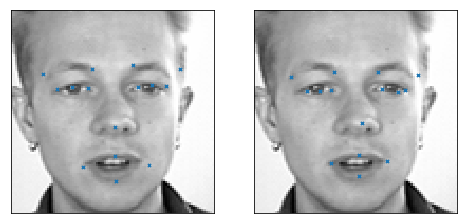

In [108]:
sample1 = load_data(test=True)[0][80:81]
sample2 = load2d(test=True)[0][80:81]
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred2, ax)
plt.show()

Left image is the prediction from net1 and Right image is the prediction from net2

Let's now plot the learning curve of net2:

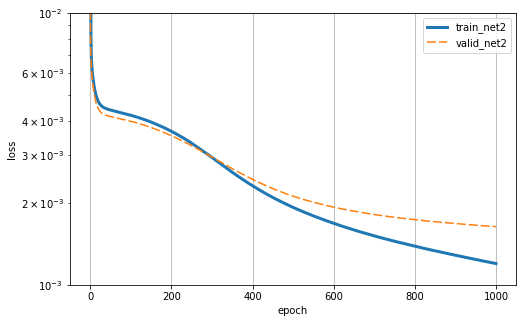

In [109]:
fig = plt.figure(figsize=(8, 5))
train_loss_net2 = np.array([i["train_loss"] for i in net2.train_history_])
valid_loss_net2 = np.array([i["valid_loss"] for i in net2.train_history_])
plt.plot(train_loss_net2, linewidth=3, label="train_net2")
plt.plot(valid_loss_net2, dashes = [6,2], label="valid_net2")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")
plt.show()

This error curves look much smoother than the earlier ones. But towards the end, the validation error of net2 flattens out much more quickly than the training error. It looks like this could far be improved by using more training examples.
But we have limited amount of data(2140). What if we flipped the input images horizontically; would we be able to improve training by doubling the amount of training data this way? Let's try to use Data Augmentation to use the same number of data more effectively.

**Data Augmentation**  

Deep artificial neural networks require a large corpus of training data in order to effectively learn, where collection of such training data is often expensive and laborious. Data augmentation overcomes this issue by artificially inflating the training set with label preserving transformations.
Data augmentation lets us artificially increase the number of training examples by applying transformations, adding noise etc. That's obviously more economic than having to go out and collect more examples by hand. 

It is the batch iterator's job to take a matrix of samples, and split it up in batches, in our case of size 128. While it does the splitting, the batch iterator can also apply transformations to the data on the fly. So to produce those horizontal flips, we don't actually have to double the amount of training data in the input matrix. Rather, we will just perform the horizontal flips with 50% chance while we're iterating over the data. This is convenient, and for some problems it allows us to produce an infinite number of examples, without blowing up the memory usage.

Flipping the images horizontically can easily be done using slicing:

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

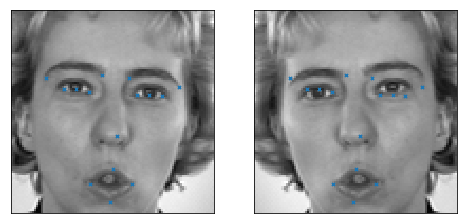

In [110]:
X, y = load2d()
X_flipped = X[:, :, :, ::-1]  # simple slice to flip all images

# plot two images:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[94], y[94], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[94], y[94], ax)
plt.show()

In the picture on the right, notice that the target value keypoints aren't aligned with the image anymore. Since we're flipping the images, we'll have to make sure we also flip the target values. To do this, not only do we have to flip the coordinates, we'll also have to swap target value positions; that's because the flipped left_eye_center_x no longer points to the left eye in our flipped image; now it corresponds to right_eye_center_x.  
Since left_eye_center_x will need to swap places with right_eye_center_x, we write down the tuple (0, 2). Also left_eye_center_y needs to swap places: with right_eye_center_y. Thus we write down (1, 3), and so on. In the end, we have:

In [111]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


Our batch iterator implementation will derive from the default BatchIterator class and override the transform() method only. Let's see how it looks like when we put it all together:

In [112]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

**Third Model: CNN with Data Augmentation and FlipBatchIterator: net3**  
To use this batch iterator for training, we'll pass it as the batch_iterator_train argument to NeuralNet. Let's define net3, a network that looks exactly the same as net2 except for these lines at the very end:

In [113]:
net3 = NeuralNet(
    
    layers=[# three convolutional layers and two fully connected layers
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    # optimization method:
    update_learning_rate=0.01,
    update_momentum=0.9,
   
    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    max_epochs=3000,
    verbose=1,
    )

Now we're passing our FlipBatchIterator, but we've also tripled the number of epochs to train. While each one of our training epochs will still look at the same number of examples as before, it turns out that training nevertheless takes quite a bit longer when we use our transforming FlipBatchIterator. This is because what the network learns generalizes better this time, and it's arguably harder to learn things that generalize than to overfit.

In [18]:
net3.fit(X, y)

# pickle the trained model so that it can be loaded later

import cPickle as pickle
with open('net3.pickle', 'wb') as f:
    pickle.dump(net3, f, -1)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.11359     0.04238    2.68063  26.34s
      2     0.01843     0.00895    2.05939  26.07s
      3     0.00871     0.00739    1.17822  26.35s
      4     0.00740     0.00689    1.07473  26.33s
      5     0.00697     0.00654    1.06648  26.25s
      6     0.00669     0.00629    1.06359  27.48s
      7     0.00645     0.00607    1.06243  26.19s
      8     0.00625     0.00587    1.06370  26.14s
      9     0.00606     0.00571    1.06091  26.26s
     10     0.00591     0.00556    1.06224  26.12s
     11     0.00577     0.00543    1.06148  26.21s
     12

    117     0.00423     0.00398    1.06381  27.55s
    118     0.00423     0.00397    1.06524  27.39s
    119     0.00422     0.00398    1.05892  27.52s
    120     0.00421     0.00398    1.05849  27.45s
    121     0.00421     0.00396    1.06260  27.42s
    122     0.00420     0.00395    1.06352  27.55s
    123     0.00421     0.00397    1.05968  27.43s
    124     0.00420     0.00395    1.06338  27.45s
    125     0.00420     0.00396    1.06063  27.59s
    126     0.00419     0.00395    1.06000  27.46s
    127     0.00419     0.00395    1.06054  27.48s
    128     0.00418     0.00394    1.05963  27.68s
    129     0.00418     0.00394    1.06197  27.51s
    130     0.00417     0.00393    1.06131  27.55s
    131     0.00417     0.00392    1.06280  27.36s
    132     0.00416     0.00392    1.06135  27.60s
    133     0.00416     0.00392    1.05993  27.55s
    134     0.00415     0.00391    1.06069  27.39s
    135     0.00415     0.00390    1.06307  27.51s
    136     0.00414     0.00392

    247     0.00368     0.00349    1.05419  27.50s
    248     0.00367     0.00348    1.05450  27.43s
    249     0.00367     0.00349    1.05076  27.41s
    250     0.00367     0.00349    1.05122  27.47s
    251     0.00367     0.00347    1.05817  27.40s
    252     0.00365     0.00348    1.05107  27.36s
    253     0.00366     0.00347    1.05617  27.36s
    254     0.00365     0.00346    1.05525  27.51s
    255     0.00364     0.00347    1.05041  27.43s
    256     0.00364     0.00347    1.05115  27.55s
    257     0.00364     0.00346    1.05151  27.47s
    258     0.00363     0.00345    1.05240  27.52s
    259     0.00363     0.00345    1.05367  27.56s
    260     0.00363     0.00345    1.05128  27.38s
    261     0.00361     0.00345    1.04877  27.36s
    262     0.00361     0.00344    1.04971  27.48s
    263     0.00361     0.00343    1.05131  30.35s
    264     0.00361     0.00343    1.05164  39.83s
    265     0.00360     0.00342    1.05167  48.53s
    266     0.00360     0.00342

    377     0.00303     0.00296    1.02324  27.57s
    378     0.00303     0.00296    1.02396  28.51s
    379     0.00303     0.00295    1.02501  30.45s
    380     0.00301     0.00294    1.02170  40.75s
    381     0.00300     0.00295    1.01813  38.88s
    382     0.00300     0.00293    1.02528  31.37s
    383     0.00300     0.00293    1.02386  32.02s
    384     0.00301     0.00293    1.02490  30.86s
    385     0.00298     0.00292    1.02376  28.19s
    386     0.00298     0.00292    1.02194  28.56s
    387     0.00298     0.00292    1.02100  30.47s
    388     0.00297     0.00293    1.01386  30.61s
    389     0.00296     0.00291    1.01905  30.50s
    390     0.00297     0.00289    1.02926  30.55s
    391     0.00295     0.00289    1.01926  34.25s
    392     0.00294     0.00288    1.02187  31.86s
    393     0.00294     0.00289    1.01781  29.09s
    394     0.00294     0.00288    1.01987  29.36s
    395     0.00293     0.00287    1.02222  29.92s
    396     0.00293     0.00287

    507     0.00236     0.00241    0.98138  30.15s
    508     0.00236     0.00240    0.98610  28.66s
    509     0.00237     0.00240    0.98644  29.85s
    510     0.00236     0.00239    0.98792  29.70s
    511     0.00236     0.00239    0.98702  27.99s
    512     0.00235     0.00239    0.98451  27.80s
    513     0.00234     0.00239    0.98221  27.93s
    514     0.00234     0.00238    0.98164  28.00s
    515     0.00234     0.00238    0.98379  27.76s
    516     0.00233     0.00237    0.98401  27.88s
    517     0.00234     0.00237    0.98642  28.22s
    518     0.00233     0.00237    0.98463  28.07s
    519     0.00232     0.00237    0.98284  27.80s
    520     0.00232     0.00236    0.98257  27.68s
    521     0.00231     0.00235    0.98036  27.86s
    522     0.00231     0.00235    0.98558  27.93s
    523     0.00231     0.00235    0.98439  28.63s
    524     0.00231     0.00235    0.97992  28.85s
    525     0.00230     0.00234    0.98196  32.10s
    526     0.00230     0.00234

    638     0.00197     0.00208    0.94740  29.06s
    639     0.00197     0.00208    0.94481  29.42s
    640     0.00197     0.00208    0.94862  31.21s
    641     0.00197     0.00207    0.94849  29.85s
    642     0.00195     0.00207    0.93952  29.39s
    643     0.00196     0.00208    0.94259  29.51s
    644     0.00196     0.00207    0.94713  30.17s
    645     0.00196     0.00207    0.94909  32.01s
    646     0.00195     0.00207    0.94243  29.07s
    647     0.00194     0.00206    0.94272  28.33s
    648     0.00194     0.00206    0.94151  27.95s
    649     0.00194     0.00206    0.94104  28.16s
    650     0.00195     0.00206    0.94515  28.28s
    651     0.00194     0.00206    0.94192  27.92s
    652     0.00194     0.00205    0.94256  28.44s
    653     0.00194     0.00206    0.94179  28.14s
    654     0.00195     0.00206    0.94548  28.03s
    655     0.00195     0.00206    0.94518  28.24s
    656     0.00192     0.00205    0.93533  28.07s
    657     0.00192     0.00205

    778     0.00171     0.00191    0.89690  27.47s
    779     0.00172     0.00191    0.90382  27.71s
    780     0.00172     0.00191    0.90148  27.49s
    781     0.00172     0.00191    0.90008  27.52s
    782     0.00171     0.00191    0.89722  27.55s
    783     0.00171     0.00190    0.90073  27.64s
    784     0.00171     0.00190    0.90356  27.51s
    785     0.00172     0.00190    0.90299  27.57s
    786     0.00170     0.00190    0.89628  27.61s
    787     0.00171     0.00190    0.89884  27.42s
    788     0.00170     0.00189    0.90088  28.64s
    789     0.00171     0.00189    0.90101  27.78s
    790     0.00170     0.00189    0.89907  27.56s
    791     0.00170     0.00190    0.89412  27.54s
    792     0.00170     0.00189    0.90036  27.58s
    793     0.00170     0.00190    0.89425  27.63s
    794     0.00170     0.00190    0.89484  27.54s
    795     0.00170     0.00189    0.89753  27.57s
    796     0.00169     0.00188    0.89890  27.68s
    797     0.00169     0.00189

    924     0.00154     0.00180    0.85587  27.42s
    925     0.00155     0.00180    0.85895  27.40s
    926     0.00153     0.00180    0.85144  27.51s
    927     0.00154     0.00180    0.85573  27.55s
    928     0.00155     0.00181    0.85626  27.63s
    929     0.00154     0.00181    0.85021  27.74s
    930     0.00154     0.00181    0.85117  27.64s
    931     0.00154     0.00180    0.85623  27.37s
    932     0.00154     0.00180    0.85340  27.62s
    933     0.00153     0.00180    0.84994  27.63s
    934     0.00153     0.00180    0.85084  27.46s
    935     0.00154     0.00180    0.85588  27.49s
    936     0.00153     0.00180    0.85342  27.48s
    937     0.00153     0.00180    0.85037  27.59s
    938     0.00153     0.00179    0.85541  27.58s
    939     0.00152     0.00180    0.84578  27.52s
    940     0.00152     0.00179    0.85144  27.59s
    941     0.00152     0.00179    0.85045  27.68s
    942     0.00152     0.00179    0.84811  27.58s
    943     0.00152     0.00179

   1072     0.00141     0.00172    0.81870  27.47s
   1073     0.00141     0.00173    0.81408  27.60s
   1074     0.00141     0.00172    0.81892  27.53s
   1075     0.00141     0.00173    0.81504  27.55s
   1076     0.00140     0.00172    0.81377  27.65s
   1077     0.00140     0.00172    0.81320  27.71s
   1078     0.00140     0.00172    0.81457  27.55s
   1079     0.00141     0.00173    0.81504  27.63s
   1080     0.00141     0.00172    0.81831  27.76s
   1081     0.00140     0.00172    0.81008  27.61s
   1082     0.00139     0.00172    0.81009  27.53s
   1083     0.00140     0.00173    0.81235  27.64s
   1084     0.00140     0.00172    0.81120  27.54s
   1085     0.00140     0.00172    0.81156  27.66s
   1086     0.00140     0.00172    0.81905  27.57s
   1087     0.00139     0.00171    0.81177  27.50s
   1088     0.00140     0.00172    0.81076  27.99s
   1089     0.00140     0.00171    0.81853  27.74s
   1090     0.00140     0.00172    0.81432  27.67s
   1091     0.00139     0.00171

   1222     0.00130     0.00167    0.77942  27.58s
   1223     0.00130     0.00166    0.77907  27.73s
   1224     0.00130     0.00166    0.78402  27.66s
   1225     0.00130     0.00166    0.78053  27.73s
   1226     0.00130     0.00166    0.77811  27.65s
   1227     0.00130     0.00166    0.78104  27.66s
   1228     0.00130     0.00166    0.78396  27.57s
   1229     0.00130     0.00166    0.78263  27.60s
   1230     0.00130     0.00166    0.78352  27.72s
   1231     0.00129     0.00167    0.77549  27.70s
   1232     0.00130     0.00165    0.78479  27.87s
   1233     0.00130     0.00166    0.77849  27.64s
   1234     0.00130     0.00166    0.78335  27.57s
   1235     0.00129     0.00165    0.78194  27.67s
   1236     0.00129     0.00166    0.77590  27.69s
   1237     0.00129     0.00166    0.77705  27.51s
   1238     0.00130     0.00166    0.77922  27.64s
   1239     0.00129     0.00166    0.78135  27.60s
   1240     0.00129     0.00166    0.77577  27.46s
   1241     0.00129     0.00166

   1372     0.00121     0.00162    0.74316  27.62s
   1373     0.00121     0.00161    0.74916  27.60s
   1374     0.00121     0.00161    0.75189  27.61s
   1375     0.00121     0.00161    0.74837  27.61s
   1376     0.00121     0.00161    0.74902  27.58s
   1377     0.00120     0.00161    0.74814  27.67s
   1378     0.00121     0.00161    0.74956  27.54s
   1379     0.00121     0.00162    0.74684  27.58s
   1380     0.00121     0.00161    0.75147  27.63s
   1381     0.00120     0.00161    0.74458  27.49s
   1382     0.00120     0.00161    0.74492  27.71s
   1383     0.00121     0.00161    0.74888  27.96s
   1384     0.00121     0.00161    0.75003  27.59s
   1385     0.00121     0.00161    0.74995  27.53s
   1386     0.00121     0.00161    0.75368  27.58s
   1387     0.00120     0.00160    0.74581  27.77s
   1388     0.00121     0.00161    0.75185  27.72s
   1389     0.00120     0.00161    0.74634  27.62s
   1390     0.00120     0.00161    0.74642  27.69s
   1391     0.00120     0.00160

   1523     0.00113     0.00157    0.72033  27.64s
   1524     0.00113     0.00157    0.72163  27.74s
   1525     0.00113     0.00156    0.72194  27.76s
   1526     0.00113     0.00157    0.71838  27.55s
   1527     0.00113     0.00156    0.72513  27.41s
   1528     0.00113     0.00157    0.72259  27.57s
   1529     0.00112     0.00158    0.71265  27.61s
   1530     0.00113     0.00157    0.71881  27.63s
   1531     0.00113     0.00157    0.71862  30.08s
   1532     0.00113     0.00156    0.72158  32.84s
   1533     0.00113     0.00157    0.71962  48.83s
   1534     0.00114     0.00157    0.72620  31.98s
   1535     0.00113     0.00156    0.72028  29.16s
   1536     0.00113     0.00156    0.72415  28.62s
   1537     0.00113     0.00156    0.72220  28.87s
   1538     0.00113     0.00156    0.72162  29.17s
   1539     0.00112     0.00157    0.71397  28.65s
   1540     0.00112     0.00156    0.71882  28.93s
   1541     0.00113     0.00156    0.72429  28.93s
   1542     0.00112     0.00156

   1675     0.00107     0.00153    0.69769  30.80s
   1676     0.00106     0.00154    0.69159  30.50s
   1677     0.00106     0.00153    0.69509  30.34s
   1678     0.00106     0.00153    0.69344  28.30s
   1679     0.00106     0.00153    0.69623  27.66s
   1680     0.00106     0.00153    0.68923  27.75s
   1681     0.00106     0.00153    0.69113  167.19s
   1682     0.00106     0.00153    0.69590  31.55s
   1683     0.00106     0.00153    0.69388  32.96s
   1684     0.00106     0.00153    0.68889  30.25s
   1685     0.00106     0.00153    0.68927  31.58s
   1686     0.00106     0.00153    0.69098  32.44s
   1687     0.00106     0.00153    0.69076  31.43s
   1688     0.00106     0.00153    0.69456  34.79s
   1689     0.00106     0.00153    0.69148  33.54s
   1690     0.00105     0.00153    0.68877  33.42s
   1691     0.00106     0.00153    0.69024  33.96s
   1692     0.00106     0.00153    0.69177  33.87s
   1693     0.00105     0.00153    0.68311  32.88s
   1694     0.00106     0.0015

   1829     0.00100     0.00150    0.66812  32.55s
   1830     0.00101     0.00151    0.66802  33.28s
   1831     0.00100     0.00150    0.66966  31.85s
   1832     0.00100     0.00150    0.66578  29.86s
   1833     0.00099     0.00150    0.66444  30.19s
   1834     0.00100     0.00150    0.66910  30.57s
   1835     0.00100     0.00150    0.66477  30.47s
   1836     0.00100     0.00149    0.66971  30.40s
   1837     0.00099     0.00150    0.66469  30.06s
   1838     0.00100     0.00149    0.66957  30.59s
   1839     0.00099     0.00150    0.66276  32.16s
   1840     0.00100     0.00150    0.66796  30.16s
   1841     0.00099     0.00150    0.66129  29.81s
   1842     0.00100     0.00150    0.66525  29.20s
   1843     0.00099     0.00150    0.66503  29.01s
   1844     0.00100     0.00151    0.66280  29.16s
   1845     0.00099     0.00150    0.66314  28.91s
   1846     0.00099     0.00150    0.66210  29.24s
   1847     0.00100     0.00149    0.67223  29.29s
   1848     0.00100     0.00150

   1983     0.00095     0.00147    0.64585  30.03s
   1984     0.00095     0.00147    0.64212  30.44s
   1985     0.00095     0.00147    0.64210  30.23s
   1986     0.00094     0.00147    0.64158  30.14s
   1987     0.00094     0.00147    0.63961  33.39s
   1988     0.00095     0.00147    0.64457  29.94s
   1989     0.00095     0.00147    0.64503  30.08s
   1990     0.00094     0.00147    0.64248  29.71s
   1991     0.00094     0.00148    0.63963  30.00s
   1992     0.00094     0.00147    0.64495  29.90s
   1993     0.00095     0.00146    0.65030  30.20s
   1994     0.00094     0.00147    0.64055  31.29s
   1995     0.00094     0.00147    0.63992  33.88s
   1996     0.00095     0.00147    0.64417  32.16s
   1997     0.00095     0.00147    0.64256  31.56s
   1998     0.00094     0.00147    0.63616  31.30s
   1999     0.00094     0.00147    0.64053  31.07s
   2000     0.00095     0.00147    0.64485  31.92s
   2001     0.00094     0.00147    0.64273  33.83s
   2002     0.00095     0.00146

   2138     0.00090     0.00145    0.62213  33.47s
   2139     0.00090     0.00146    0.61834  32.94s
   2140     0.00090     0.00145    0.61936  29.66s
   2141     0.00090     0.00145    0.61709  29.12s
   2142     0.00090     0.00145    0.61731  29.13s
   2143     0.00089     0.00145    0.61411  29.23s
   2144     0.00089     0.00144    0.61937  29.17s
   2145     0.00089     0.00145    0.61482  29.18s
   2146     0.00089     0.00144    0.61820  30.57s
   2147     0.00090     0.00144    0.62108  29.25s
   2148     0.00090     0.00145    0.62081  29.17s
   2149     0.00090     0.00145    0.61639  29.24s
   2150     0.00089     0.00144    0.61901  29.30s
   2151     0.00089     0.00144    0.61950  29.29s
   2152     0.00089     0.00144    0.61947  29.21s
   2153     0.00090     0.00145    0.61801  29.19s
   2154     0.00090     0.00145    0.61697  28.98s
   2155     0.00090     0.00145    0.61958  29.15s
   2156     0.00090     0.00145    0.61787  29.13s
   2157     0.00090     0.00144

   2293     0.00085     0.00143    0.59600  28.02s
   2294     0.00086     0.00143    0.59688  27.73s
   2295     0.00085     0.00142    0.59807  27.86s
   2296     0.00085     0.00144    0.59520  27.92s
   2297     0.00086     0.00143    0.60430  27.96s
   2298     0.00085     0.00143    0.59478  27.85s
   2299     0.00085     0.00142    0.59985  27.72s
   2300     0.00085     0.00143    0.59297  27.74s
   2301     0.00085     0.00144    0.59052  27.77s
   2302     0.00085     0.00143    0.59336  27.84s
   2303     0.00085     0.00143    0.59645  27.87s
   2304     0.00085     0.00143    0.59457  27.73s
   2305     0.00085     0.00142    0.59816  27.90s
   2306     0.00085     0.00142    0.59935  27.97s
   2307     0.00085     0.00143    0.59526  27.83s
   2308     0.00085     0.00142    0.59964  27.84s
   2309     0.00085     0.00142    0.59514  27.77s
   2310     0.00085     0.00143    0.59639  28.04s
   2311     0.00085     0.00143    0.59571  27.84s
   2312     0.00085     0.00143

   2449     0.00082     0.00141    0.58030  29.17s
   2450     0.00081     0.00141    0.57647  28.80s
   2451     0.00081     0.00142    0.56964  28.84s
   2452     0.00081     0.00142    0.57475  28.88s
   2453     0.00081     0.00142    0.57223  29.06s
   2454     0.00081     0.00141    0.57648  28.70s
   2455     0.00081     0.00141    0.57632  29.27s
   2456     0.00081     0.00142    0.56834  28.29s
   2457     0.00081     0.00141    0.57481  27.90s
   2458     0.00081     0.00141    0.57323  27.73s
   2459     0.00081     0.00141    0.57137  28.02s
   2460     0.00081     0.00142    0.57475  27.85s
   2461     0.00081     0.00141    0.57669  27.85s
   2462     0.00081     0.00141    0.57397  27.86s
   2463     0.00081     0.00141    0.57441  27.83s
   2464     0.00081     0.00141    0.57447  27.94s
   2465     0.00081     0.00141    0.57536  27.77s
   2466     0.00081     0.00141    0.57289  27.87s
   2467     0.00081     0.00140    0.57418  27.70s
   2468     0.00081     0.00141

   2605     0.00078     0.00140    0.55216  27.75s
   2606     0.00077     0.00140    0.55429  28.22s
   2607     0.00078     0.00140    0.55910  27.96s
   2608     0.00077     0.00140    0.55487  27.94s
   2609     0.00077     0.00140    0.55441  27.89s
   2610     0.00077     0.00140    0.55236  27.93s
   2611     0.00078     0.00140    0.55571  28.00s
   2612     0.00078     0.00140    0.55573  27.90s
   2613     0.00077     0.00139    0.55501  28.02s
   2614     0.00078     0.00139    0.55847  27.88s
   2615     0.00077     0.00140    0.55326  27.85s
   2616     0.00077     0.00142    0.54610  27.88s
   2617     0.00077     0.00141    0.54715  27.96s
   2618     0.00077     0.00141    0.54536  27.86s
   2619     0.00077     0.00141    0.54842  27.89s
   2620     0.00077     0.00141    0.54745  27.73s
   2621     0.00077     0.00140    0.55103  28.00s
   2622     0.00077     0.00140    0.55160  27.94s
   2623     0.00077     0.00140    0.54930  28.13s
   2624     0.00077     0.00140

   2761     0.00074     0.00139    0.53102  28.00s
   2762     0.00074     0.00138    0.53708  27.99s
   2763     0.00074     0.00139    0.53422  27.91s
   2764     0.00074     0.00140    0.52593  28.04s
   2765     0.00073     0.00138    0.53138  27.92s
   2766     0.00074     0.00140    0.52980  27.71s
   2767     0.00074     0.00139    0.53518  28.58s
   2768     0.00074     0.00139    0.53103  27.88s
   2769     0.00074     0.00140    0.52418  27.94s
   2770     0.00074     0.00139    0.53120  28.21s
   2771     0.00074     0.00138    0.53439  27.91s
   2772     0.00073     0.00139    0.52585  27.90s
   2773     0.00074     0.00138    0.53436  32.94s
   2774     0.00074     0.00139    0.53076  29.17s
   2775     0.00073     0.00138    0.53111  29.10s
   2776     0.00074     0.00139    0.53191  29.45s
   2777     0.00074     0.00138    0.53389  29.18s
   2778     0.00074     0.00138    0.53286  28.98s
   2779     0.00073     0.00140    0.52531  29.32s
   2780     0.00074     0.00138

   2917     0.00072     0.00137    0.52287  28.04s
   2918     0.00071     0.00139    0.50665  27.92s
   2919     0.00071     0.00140    0.50501  27.82s
   2920     0.00071     0.00137    0.51720  27.82s
   2921     0.00071     0.00137    0.51419  27.90s
   2922     0.00071     0.00139    0.51141  27.93s
   2923     0.00071     0.00138    0.51888  27.91s
   2924     0.00070     0.00138    0.51029  27.78s
   2925     0.00071     0.00137    0.51420  27.87s
   2926     0.00070     0.00137    0.51414  27.81s
   2927     0.00071     0.00137    0.51452  27.99s
   2928     0.00071     0.00137    0.51620  27.79s
   2929     0.00071     0.00138    0.50983  27.95s
   2930     0.00070     0.00137    0.51250  27.93s
   2931     0.00070     0.00137    0.51290  27.96s
   2932     0.00071     0.00138    0.51511  28.12s
   2933     0.00071     0.00138    0.51776  28.49s
   2934     0.00071     0.00139    0.50764  27.87s
   2935     0.00071     0.00142    0.50236  27.73s
   2936     0.00071     0.00138

In [114]:
# build net3 from pickle file without running the model one more time

net3 = pickle.loads(open("net3.pickle", "rb").read())

In [115]:
print "Validation Loss for net3 = ", 0.00137
print "RMSE for net3 = ", np.sqrt(0.00137)*48

Validation Loss for net3 =  0.00137
RMSE for net3 =  1.77664853024


Let's plot the learning rate for net3:

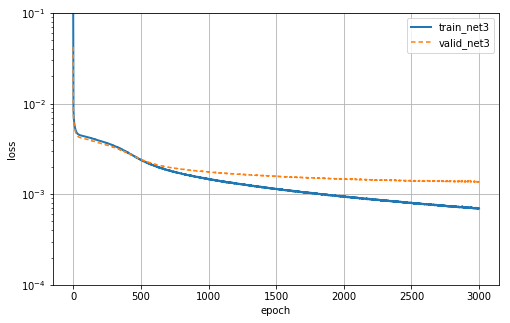

In [117]:
fig = plt.figure(figsize=(8, 5))
train_loss_net3 = np.array([i["train_loss"] for i in net3.train_history_])
valid_loss_net3 = np.array([i["valid_loss"] for i in net3.train_history_])
plt.plot(train_loss_net3, linewidth=2, label="train_net3")
plt.plot(valid_loss_net3, dashes = [3,2], label="valid_net3")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.xlim(0, 1000)
plt.ylim(1e-4, 1e-1)
plt.yscale("log")
plt.show()

net3 gives pretty good result. Our RMSE is 1.77664853024, which is good enough.

Comparing the learning with that of net2, we notice that the error on the validation set after 3000 epochs is indeed about 5% smaller for the data augmented net. We can see how net3 continues to improve its validation error throughout, though slowly.

The only problem with this net is it's too slow to get trained.
Will try to make the training faster by changing learning rate and momentum.
So far we have initialized our learning rate to be 0.1 and momentum to be 0.9.

An intuition behind starting with a higher learning rate and decreasing it during the course of training is this: As we start training, we're far away from the optimum, and we want to take big steps towards it and learn quickly. But the closer we get to the optimum, the lighter we want to step. 
Let's change that such that the learning rate decreases linearly with the number of epochs, while we let the momentum increase.

**Changing learning rate and momentum over time**

NeuralNet allows us to update parameters during training using the on_epoch_finished hook. We can pass a function to on_epoch_finished and it'll be called whenever an epoch is finished. However, before we can assign new values to update_learning_rate and update_momentum on the fly, we'll have to change these two parameters to become Theano shared variables.

In [118]:
def float32(k):
    return np.cast['float32'](k)

The callback or list of callbacks that we pass will be called with two arguments: nn, which is the NeuralNet instance itself, and train_history, which is the same as nn.train_history_.

Instead of working with callback functions that use hard-coded values, we'll use a parametrizable class with a __call__ method as our callback. Let's call this class AdjustVariable.

In [119]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

**Regularization to limit Over-fit problem: Introduce Dropout**  

Before starting next set of training using this modified learning rate and momentum, we will try to reduce overfit by introducing regularization.  
Dropout is a popular regularization technique that works amazingly well with neural net. Like with any other regularization technique, dropout only makes sense if we have a network that's overfitting, which is clearly our case here. 

**Fourth Model: CNN with Augmentation,modified Learning Rate/Momentum and Dropout: net_dropout**  

To use dropout with Lasagne, we'll add DropoutLayer layers between the existing layers and assign dropout probabilities to each one of them. Here's the complete definition of our new net:

In [120]:
net_dropout = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  # !
    hidden4_num_units=500,
    dropout4_p=0.5,  # !
    hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=3000,
    verbose=1,
    )

Our network is sufficiently large now to crash Python's pickle with a maximum recursion error. Therefore we have to increase Python's recursion limit before we save it:

In [67]:
sys.setrecursionlimit(10000)

X, y = load2d()
net_dropout.fit(X, y)

# pickle the trained model so that it can be loaded later

import cPickle as pickle
with open('net_dropout.pickle', 'wb') as f:
    pickle.dump(net_dropout, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

    105     0.00435     0.00416    1.04678  31.42s
    106     0.00435     0.00416    1.04738  31.55s
    107     0.00433     0.00414    1.04430  31.41s
    108     0.00433     0.00414    1.04539  31.43s
    109     0.00433     0.00414    1.04537  31.48s
    110     0.00435     0.00414    1.05027  31.50s
    111     0.00433     0.00414    1.04587  32.49s
    112     0.00433     0.00414    1.04686  31.58s
    113     0.00432     0.00414    1.04547  31.48s
    114     0.00432     0.00412    1.04884  31.36s
    115     0.00433     0.00413    1.04741  31.50s
    116     0.00431     0.00411    1.04827  31.59s
    117     0.00431     0.00412    1.04566  31.36s
    118     0.00430     0.00411    1.04509  31.53s
    119     0.00430     0.00411    1.04546  31.47s
    120     0.00431     0.00411    1.04814  31.55s
    121     0.00430     0.00410    1.04696  31.45s
    122     0.00430     0.00410    1.04792  31.45s
    123     0.00430     0.00410    1.04841  31.46s
    124     0.00430     0.00410

    237     0.00387     0.00361    1.07111  34.40s
    238     0.00389     0.00362    1.07536  32.80s
    239     0.00387     0.00361    1.07260  33.65s
    240     0.00388     0.00360    1.07595  35.18s
    241     0.00387     0.00360    1.07686  33.04s
    242     0.00387     0.00359    1.07638  40.22s
    243     0.00385     0.00359    1.07243  35.12s
    244     0.00383     0.00358    1.07136  32.96s
    245     0.00386     0.00358    1.07823  32.90s
    246     0.00384     0.00356    1.07736  33.05s
    247     0.00383     0.00356    1.07835  33.20s
    248     0.00382     0.00356    1.07537  32.99s
    249     0.00383     0.00355    1.07948  32.95s
    250     0.00382     0.00354    1.07756  32.96s
    251     0.00381     0.00353    1.07928  32.90s
    252     0.00382     0.00354    1.07959  33.19s
    253     0.00380     0.00353    1.07664  32.23s
    254     0.00378     0.00352    1.07586  32.08s
    255     0.00379     0.00351    1.07843  32.06s
    256     0.00378     0.00351

    368     0.00317     0.00281    1.13142  32.11s
    369     0.00315     0.00280    1.12748  32.05s
    370     0.00315     0.00279    1.12809  31.97s
    371     0.00316     0.00279    1.13137  31.97s
    372     0.00315     0.00278    1.13231  31.85s
    373     0.00314     0.00277    1.13070  32.02s
    374     0.00312     0.00277    1.12560  32.19s
    375     0.00313     0.00276    1.13210  37.08s
    376     0.00311     0.00276    1.12724  32.92s
    377     0.00312     0.00275    1.13606  32.85s
    378     0.00313     0.00275    1.13844  34.15s
    379     0.00312     0.00273    1.14099  32.82s
    380     0.00308     0.00272    1.13210  32.73s
    381     0.00310     0.00273    1.13579  32.82s
    382     0.00307     0.00272    1.12993  32.66s
    383     0.00309     0.00271    1.14125  32.73s
    384     0.00306     0.00270    1.13274  32.86s
    385     0.00309     0.00270    1.14564  32.81s
    386     0.00307     0.00270    1.13566  32.79s
    387     0.00305     0.00268

    504     0.00261     0.00222    1.17537  32.13s
    505     0.00258     0.00222    1.16261  32.16s
    506     0.00259     0.00222    1.17037  32.10s
    507     0.00259     0.00221    1.17224  32.06s
    508     0.00257     0.00221    1.16075  32.03s
    509     0.00258     0.00220    1.17408  31.95s
    510     0.00256     0.00219    1.16807  32.07s
    511     0.00258     0.00220    1.17368  32.03s
    512     0.00258     0.00219    1.17721  32.06s
    513     0.00256     0.00220    1.16223  32.07s
    514     0.00254     0.00219    1.15731  31.92s
    515     0.00257     0.00218    1.18137  31.92s
    516     0.00257     0.00218    1.17887  31.95s
    517     0.00256     0.00218    1.17629  32.10s
    518     0.00253     0.00218    1.16057  32.12s
    519     0.00256     0.00217    1.17874  32.03s
    520     0.00253     0.00218    1.16438  32.04s
    521     0.00255     0.00217    1.17367  32.08s
    522     0.00253     0.00217    1.16549  32.52s
    523     0.00254     0.00216

    647     0.00229     0.00195    1.17395  32.28s
    648     0.00230     0.00194    1.18223  32.23s
    649     0.00227     0.00194    1.16708  32.35s
    650     0.00226     0.00194    1.16652  32.15s
    651     0.00227     0.00194    1.16795  32.08s
    652     0.00226     0.00194    1.16722  32.06s
    653     0.00227     0.00193    1.17324  32.16s
    654     0.00225     0.00194    1.15790  32.18s
    655     0.00224     0.00192    1.16338  32.15s
    656     0.00226     0.00193    1.17349  32.22s
    657     0.00228     0.00193    1.18248  31.89s
    658     0.00225     0.00193    1.16684  32.18s
    659     0.00225     0.00193    1.17080  32.19s
    660     0.00225     0.00192    1.17359  32.29s
    661     0.00228     0.00193    1.18376  32.19s
    662     0.00227     0.00192    1.18195  32.23s
    663     0.00228     0.00192    1.18468  32.11s
    664     0.00225     0.00192    1.17517  32.17s
    665     0.00227     0.00192    1.18273  32.11s
    666     0.00226     0.00191

    795     0.00208     0.00178    1.17314  32.77s
    796     0.00208     0.00177    1.17466  32.98s
    797     0.00210     0.00177    1.18525  32.90s
    798     0.00210     0.00177    1.18234  32.81s
    799     0.00209     0.00177    1.18054  32.74s
    800     0.00208     0.00177    1.17917  32.90s
    801     0.00209     0.00177    1.17799  32.83s
    802     0.00205     0.00177    1.15883  32.91s
    803     0.00209     0.00177    1.18131  33.21s
    804     0.00210     0.00177    1.18931  32.06s
    805     0.00207     0.00177    1.17206  32.05s
    806     0.00209     0.00177    1.18329  32.15s
    807     0.00208     0.00176    1.17868  32.01s
    808     0.00209     0.00176    1.18842  32.16s
    809     0.00206     0.00176    1.16909  32.17s
    810     0.00207     0.00176    1.17292  32.61s
    811     0.00209     0.00176    1.19010  32.15s
    812     0.00205     0.00176    1.16473  32.12s
    813     0.00204     0.00176    1.15817  32.14s
    814     0.00208     0.00176

    943     0.00194     0.00166    1.17473  32.13s
    944     0.00193     0.00165    1.16897  32.19s
    945     0.00193     0.00166    1.16885  32.20s
    946     0.00194     0.00165    1.17512  32.19s
    947     0.00194     0.00165    1.17711  31.99s
    948     0.00195     0.00165    1.18143  32.16s
    949     0.00193     0.00165    1.16671  32.18s
    950     0.00192     0.00165    1.16761  32.09s
    951     0.00194     0.00165    1.17669  32.09s
    952     0.00194     0.00164    1.18069  32.16s
    953     0.00195     0.00165    1.18088  32.21s
    954     0.00194     0.00165    1.17927  32.13s
    955     0.00196     0.00165    1.18751  32.17s
    956     0.00194     0.00165    1.17305  32.16s
    957     0.00193     0.00164    1.17609  32.11s
    958     0.00193     0.00164    1.17504  32.12s
    959     0.00192     0.00164    1.17057  32.02s
    960     0.00193     0.00164    1.17394  32.14s
    961     0.00192     0.00164    1.17357  32.19s
    962     0.00194     0.00164

   1092     0.00183     0.00156    1.17033  32.19s
   1093     0.00184     0.00156    1.17738  32.33s
   1094     0.00184     0.00156    1.17824  32.23s
   1095     0.00182     0.00156    1.16721  32.14s
   1096     0.00182     0.00156    1.16710  32.23s
   1097     0.00182     0.00156    1.16547  32.08s
   1098     0.00184     0.00156    1.17693  32.12s
   1099     0.00181     0.00156    1.15826  32.09s
   1100     0.00182     0.00156    1.16847  32.24s
   1101     0.00184     0.00156    1.18002  32.20s
   1102     0.00184     0.00155    1.18369  32.27s
   1103     0.00183     0.00156    1.17674  32.16s
   1104     0.00183     0.00156    1.17637  32.14s
   1105     0.00182     0.00156    1.16784  32.14s
   1106     0.00183     0.00155    1.17810  32.12s
   1107     0.00181     0.00155    1.16903  32.29s
   1108     0.00181     0.00156    1.16370  32.20s
   1109     0.00182     0.00156    1.16984  32.16s
   1110     0.00185     0.00155    1.19273  32.13s
   1111     0.00184     0.00156

   1243     0.00175     0.00149    1.17506  32.15s
   1244     0.00178     0.00149    1.19677  32.23s
   1245     0.00176     0.00149    1.18046  32.20s
   1246     0.00176     0.00149    1.18196  32.12s
   1247     0.00176     0.00149    1.17704  32.15s
   1248     0.00177     0.00149    1.18569  32.13s
   1249     0.00174     0.00149    1.16879  32.10s
   1250     0.00174     0.00149    1.17103  32.29s
   1251     0.00176     0.00149    1.18451  32.19s
   1252     0.00176     0.00149    1.17937  32.23s
   1253     0.00172     0.00148    1.15998  32.28s
   1254     0.00177     0.00149    1.18674  32.23s
   1255     0.00175     0.00148    1.17624  32.28s
   1256     0.00173     0.00148    1.16907  32.32s
   1257     0.00173     0.00148    1.16757  32.29s
   1258     0.00175     0.00148    1.18533  32.28s
   1259     0.00176     0.00148    1.18882  32.26s
   1260     0.00173     0.00148    1.16908  32.22s
   1261     0.00176     0.00149    1.18407  32.26s
   1262     0.00173     0.00148

   1396     0.00168     0.00143    1.17248  32.13s
   1397     0.00169     0.00143    1.18393  32.13s
   1398     0.00168     0.00143    1.17865  32.11s
   1399     0.00166     0.00143    1.16550  32.21s
   1400     0.00167     0.00143    1.17251  32.18s
   1401     0.00167     0.00143    1.17011  32.24s
   1402     0.00168     0.00143    1.17156  32.20s
   1403     0.00166     0.00143    1.16514  32.16s
   1404     0.00169     0.00143    1.18775  32.11s
   1405     0.00167     0.00143    1.17004  32.14s
   1406     0.00167     0.00143    1.16609  32.21s
   1407     0.00168     0.00142    1.17612  32.07s
   1408     0.00168     0.00143    1.17623  32.05s
   1409     0.00166     0.00143    1.16297  32.15s
   1410     0.00170     0.00143    1.19001  32.27s
   1411     0.00165     0.00143    1.15945  32.08s
   1412     0.00168     0.00142    1.18208  32.21s
   1413     0.00168     0.00142    1.18382  32.08s
   1414     0.00167     0.00142    1.17793  32.22s
   1415     0.00168     0.00142

   1550     0.00161     0.00138    1.16903  32.32s
   1551     0.00160     0.00138    1.16622  32.32s
   1552     0.00161     0.00138    1.16595  32.23s
   1553     0.00163     0.00138    1.18364  32.12s
   1554     0.00161     0.00138    1.16681  32.14s
   1555     0.00161     0.00138    1.17132  32.20s
   1556     0.00163     0.00138    1.18100  32.09s
   1557     0.00163     0.00138    1.18588  32.18s
   1558     0.00158     0.00137    1.14730  32.09s
   1559     0.00161     0.00138    1.16705  32.11s
   1560     0.00162     0.00137    1.18030  32.09s
   1561     0.00161     0.00137    1.17441  32.15s
   1562     0.00162     0.00137    1.17777  31.99s
   1563     0.00161     0.00137    1.17358  32.17s
   1564     0.00162     0.00137    1.18115  32.19s
   1565     0.00164     0.00137    1.19776  32.11s
   1566     0.00163     0.00137    1.18751  32.09s
   1567     0.00162     0.00138    1.18020  32.24s
   1568     0.00159     0.00138    1.15799  32.25s
   1569     0.00160     0.00137

   1705     0.00158     0.00134    1.17788  32.21s
   1706     0.00158     0.00134    1.18057  32.07s
   1707     0.00155     0.00134    1.16154  32.20s
   1708     0.00157     0.00133    1.18188  32.20s
   1709     0.00157     0.00133    1.17899  32.23s
   1710     0.00159     0.00133    1.19272  32.14s
   1711     0.00156     0.00133    1.17446  32.16s
   1712     0.00156     0.00133    1.16733  32.16s
   1713     0.00155     0.00133    1.16560  32.10s
   1714     0.00156     0.00133    1.16892  32.21s
   1715     0.00157     0.00133    1.17729  32.27s
   1716     0.00155     0.00133    1.16296  32.33s
   1717     0.00158     0.00133    1.18398  32.15s
   1718     0.00153     0.00133    1.15097  32.58s
   1719     0.00157     0.00133    1.18206  32.32s
   1720     0.00158     0.00133    1.18784  32.17s
   1721     0.00157     0.00133    1.18183  32.16s
   1722     0.00157     0.00133    1.18005  32.28s
   1723     0.00155     0.00133    1.16318  32.16s
   1724     0.00156     0.00133

   1859     0.00153     0.00130    1.17939  32.25s
   1860     0.00152     0.00130    1.17142  32.24s
   1861     0.00152     0.00130    1.17277  32.11s
   1862     0.00151     0.00129    1.16550  32.15s
   1863     0.00154     0.00129    1.19314  32.24s
   1864     0.00154     0.00130    1.18835  32.15s
   1865     0.00150     0.00130    1.15562  32.23s
   1866     0.00151     0.00130    1.16694  32.09s
   1867     0.00151     0.00130    1.16659  32.22s
   1868     0.00151     0.00130    1.16521  32.25s
   1869     0.00150     0.00129    1.16287  32.29s
   1870     0.00152     0.00129    1.17614  32.29s
   1871     0.00149     0.00129    1.15492  32.25s
   1872     0.00153     0.00130    1.17996  32.33s
   1873     0.00150     0.00129    1.15944  32.22s
   1874     0.00151     0.00129    1.17137  32.22s
   1875     0.00149     0.00129    1.15770  32.22s
   1876     0.00151     0.00129    1.17117  32.24s
   1877     0.00152     0.00129    1.17751  32.23s
   1878     0.00152     0.00129

   2014     0.00148     0.00126    1.17622  32.15s
   2015     0.00146     0.00126    1.16068  32.24s
   2016     0.00148     0.00126    1.17051  32.30s
   2017     0.00148     0.00126    1.17326  32.16s
   2018     0.00148     0.00126    1.17106  32.36s
   2019     0.00149     0.00127    1.17723  32.25s
   2020     0.00148     0.00126    1.17466  32.20s
   2021     0.00151     0.00126    1.19794  32.22s
   2022     0.00147     0.00126    1.16189  32.25s
   2023     0.00147     0.00127    1.16473  32.30s
   2024     0.00147     0.00126    1.15920  32.29s
   2025     0.00148     0.00126    1.16956  32.28s
   2026     0.00150     0.00126    1.18743  32.18s
   2027     0.00145     0.00126    1.14967  32.10s
   2028     0.00148     0.00126    1.17938  32.29s
   2029     0.00147     0.00126    1.16567  32.20s
   2030     0.00148     0.00126    1.17970  32.17s
   2031     0.00146     0.00125    1.16219  32.22s
   2032     0.00147     0.00125    1.17428  32.23s
   2033     0.00145     0.00126

   2169     0.00144     0.00123    1.16856  32.17s
   2170     0.00145     0.00123    1.17885  32.22s
   2171     0.00145     0.00123    1.18005  32.10s
   2172     0.00144     0.00123    1.16873  32.18s
   2173     0.00143     0.00123    1.16075  32.13s
   2174     0.00143     0.00123    1.15976  32.09s
   2175     0.00141     0.00123    1.14383  32.18s
   2176     0.00143     0.00124    1.16093  32.16s
   2177     0.00145     0.00123    1.17580  32.31s
   2178     0.00143     0.00123    1.16008  32.07s
   2179     0.00144     0.00123    1.16466  32.14s
   2180     0.00143     0.00124    1.15982  32.13s
   2181     0.00144     0.00124    1.16257  32.13s
   2182     0.00145     0.00123    1.17480  32.12s
   2183     0.00146     0.00123    1.18744  32.19s
   2184     0.00144     0.00123    1.17256  32.31s
   2185     0.00143     0.00123    1.16663  32.06s
   2186     0.00144     0.00123    1.16742  32.26s
   2187     0.00144     0.00124    1.16183  32.21s
   2188     0.00144     0.00123

   2324     0.00139     0.00120    1.15341  32.16s
   2325     0.00141     0.00121    1.17167  32.20s
   2326     0.00139     0.00120    1.15657  32.09s
   2327     0.00140     0.00120    1.16598  32.05s
   2328     0.00141     0.00120    1.16629  32.18s
   2329     0.00141     0.00121    1.16728  32.13s
   2330     0.00140     0.00120    1.16328  32.32s
   2331     0.00139     0.00120    1.15717  32.29s
   2332     0.00140     0.00120    1.16451  32.26s
   2333     0.00141     0.00120    1.16891  32.28s
   2334     0.00140     0.00121    1.16153  32.23s
   2335     0.00140     0.00121    1.16003  32.10s
   2336     0.00140     0.00121    1.16080  32.33s
   2337     0.00140     0.00121    1.16000  32.17s
   2338     0.00141     0.00121    1.16724  32.32s
   2339     0.00139     0.00120    1.15692  32.18s
   2340     0.00140     0.00120    1.16638  32.11s
   2341     0.00139     0.00120    1.15827  32.10s
   2342     0.00142     0.00120    1.17739  32.24s
   2343     0.00141     0.00120

   2480     0.00137     0.00118    1.16014  32.14s
   2481     0.00136     0.00118    1.15542  32.22s
   2482     0.00138     0.00118    1.17126  32.13s
   2483     0.00138     0.00118    1.16488  32.26s
   2484     0.00139     0.00118    1.17280  32.14s
   2485     0.00135     0.00118    1.14303  32.20s
   2486     0.00137     0.00118    1.15588  32.26s
   2487     0.00135     0.00118    1.14312  32.25s
   2488     0.00137     0.00118    1.16527  32.25s
   2489     0.00134     0.00118    1.14056  32.10s
   2490     0.00138     0.00118    1.17016  32.20s
   2491     0.00137     0.00118    1.16454  32.15s
   2492     0.00138     0.00118    1.16637  32.15s
   2493     0.00139     0.00118    1.17635  32.13s
   2494     0.00135     0.00118    1.15171  32.20s
   2495     0.00135     0.00118    1.14452  32.11s
   2496     0.00135     0.00118    1.14449  32.20s
   2497     0.00134     0.00118    1.13531  32.22s
   2498     0.00136     0.00118    1.14921  32.04s
   2499     0.00138     0.00118

   2635     0.00134     0.00116    1.15850  32.15s
   2636     0.00135     0.00116    1.16616  32.17s
   2637     0.00136     0.00116    1.17326  32.18s
   2638     0.00134     0.00116    1.16178  32.15s
   2639     0.00135     0.00115    1.16760  32.17s
   2640     0.00133     0.00115    1.15361  32.27s
   2641     0.00134     0.00115    1.16117  32.33s
   2642     0.00132     0.00115    1.14671  32.26s
   2643     0.00133     0.00115    1.15442  32.19s
   2644     0.00133     0.00116    1.15430  32.25s
   2645     0.00133     0.00116    1.14683  32.20s
   2646     0.00134     0.00116    1.16292  32.24s
   2647     0.00136     0.00116    1.17593  32.06s
   2648     0.00136     0.00116    1.17466  32.11s
   2649     0.00134     0.00116    1.15871  32.11s
   2650     0.00135     0.00116    1.16781  32.08s
   2651     0.00135     0.00116    1.16503  32.30s
   2652     0.00132     0.00116    1.14403  32.34s
   2653     0.00132     0.00116    1.14628  32.29s
   2654     0.00133     0.00116

   2790     0.00130     0.00114    1.13812  32.06s
   2791     0.00132     0.00114    1.16086  32.11s
   2792     0.00131     0.00114    1.15042  32.24s
   2793     0.00130     0.00114    1.14231  32.18s
   2794     0.00131     0.00114    1.14472  32.22s
   2795     0.00132     0.00114    1.15803  32.08s
   2796     0.00133     0.00114    1.16388  32.09s
   2797     0.00132     0.00114    1.15794  32.10s
   2798     0.00131     0.00114    1.14834  32.18s
   2799     0.00130     0.00114    1.14606  32.12s
   2800     0.00132     0.00114    1.16138  32.18s
   2801     0.00132     0.00114    1.16550  32.03s
   2802     0.00130     0.00114    1.14077  32.07s
   2803     0.00131     0.00114    1.15253  32.18s
   2804     0.00133     0.00113    1.16741  32.23s
   2805     0.00132     0.00113    1.16173  32.16s
   2806     0.00133     0.00113    1.17534  32.23s
   2807     0.00132     0.00113    1.16282  32.08s
   2808     0.00132     0.00114    1.15849  32.40s
   2809     0.00132     0.00113

   2944     0.00130     0.00112    1.16546  31.94s
   2945     0.00130     0.00112    1.16253  32.07s
   2946     0.00129     0.00112    1.15486  32.10s
   2947     0.00131     0.00112    1.17259  32.13s
   2948     0.00129     0.00112    1.14697  32.17s
   2949     0.00131     0.00112    1.16575  32.09s
   2950     0.00131     0.00112    1.16331  32.20s
   2951     0.00129     0.00112    1.14652  32.16s
   2952     0.00130     0.00112    1.15389  32.13s
   2953     0.00130     0.00112    1.15691  32.15s
   2954     0.00129     0.00112    1.14787  32.11s
   2955     0.00130     0.00112    1.15459  32.14s
   2956     0.00129     0.00112    1.14899  32.13s
   2957     0.00132     0.00112    1.17308  32.17s
   2958     0.00128     0.00112    1.14220  32.21s
   2959     0.00130     0.00112    1.15731  32.00s
   2960     0.00130     0.00112    1.16301  32.24s
   2961     0.00128     0.00112    1.14140  32.23s
   2962     0.00130     0.00112    1.15770  32.04s
   2963     0.00128     0.00112

In [121]:
# build net_dropout from pickle file without running the model one more time

net_dropout = pickle.loads(open("net_dropout.pickle", "rb").read())

Also overfitting doesn't seem to be nearly as bad. Though we'll have to be careful with those numbers: the ratio between training and validation has a slightly different meaning now since the train error is evaluated with dropout, whereas the validation error is evaluated without dropout. A more comparable value for the train error is this:

In [122]:
mse_net_dropout = mean_squared_error(net_dropout.predict(X), y)
print "Validation Error for net_dropout = ", mse_net_dropout
print "RMSE for net_dropout = ", np.sqrt(mse_net_dropout)*48



Validation Error for net_dropout =  0.000956275
RMSE for net_dropout =  1.48433732986


In our previous model net3 without dropout, the error on the train set was 0.00070.
So not only does our dropout net perform slightly better, it overfits much less than what we had before.

Let's compare the last two nets: net3 and net_dropout:

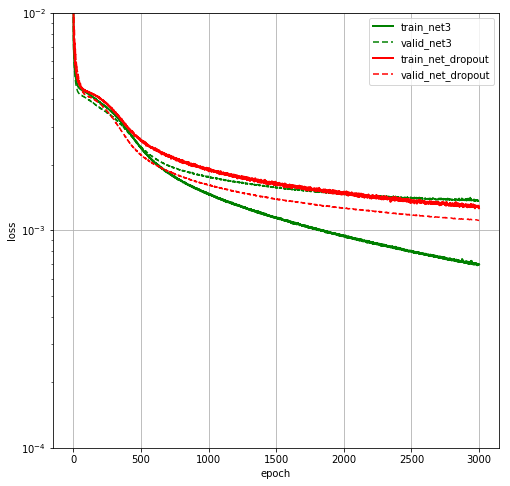

In [123]:
fig = plt.figure(figsize=(8, 8))
train_loss_net3 = np.array([i["train_loss"] for i in net3.train_history_])
valid_loss_net3 = np.array([i["valid_loss"] for i in net3.train_history_])
train_loss_net_dropout = np.array([i["train_loss"] for i in net_dropout.train_history_])
valid_loss_net_dropout = np.array([i["valid_loss"] for i in net_dropout.train_history_])
plt.plot(train_loss_net3, linewidth=2, label="train_net3", color='green')
plt.plot(valid_loss_net3, dashes = [4,2], label="valid_net3", color='green')
plt.plot(train_loss_net_dropout, linewidth=2, label="train_net_dropout", color='red')
plt.plot(valid_loss_net_dropout, dashes = [4,2], label="valid_net_dropout", color='red')
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.xlim(0, 1000)
plt.ylim(1e-4, 1e-2)
plt.yscale("log")
plt.show()

From the above plot it's very distinct that adding dropout regularization has made our net at least 5% better than net3 in regard to both overfitting and RMSE score.
**If we compare our results so far, here is the chart for RMSE:  
net1        - 2.75320903674  
net2        - 1.94385184621  
net3        - 1.77664853024  
net_dropout - 1.48433732986**  

So **net_dropout** is our best net. **RMSE score = 1.48433732986**

**Predict Test Data and point the facial elements**

Now that we trained our net nicely and reduced the over-fit using dropout to have a pretty good RMSE score of , we will try to predict the test data set and point out the facial elements:

ImageId    1783
Image      1783
dtype: int64


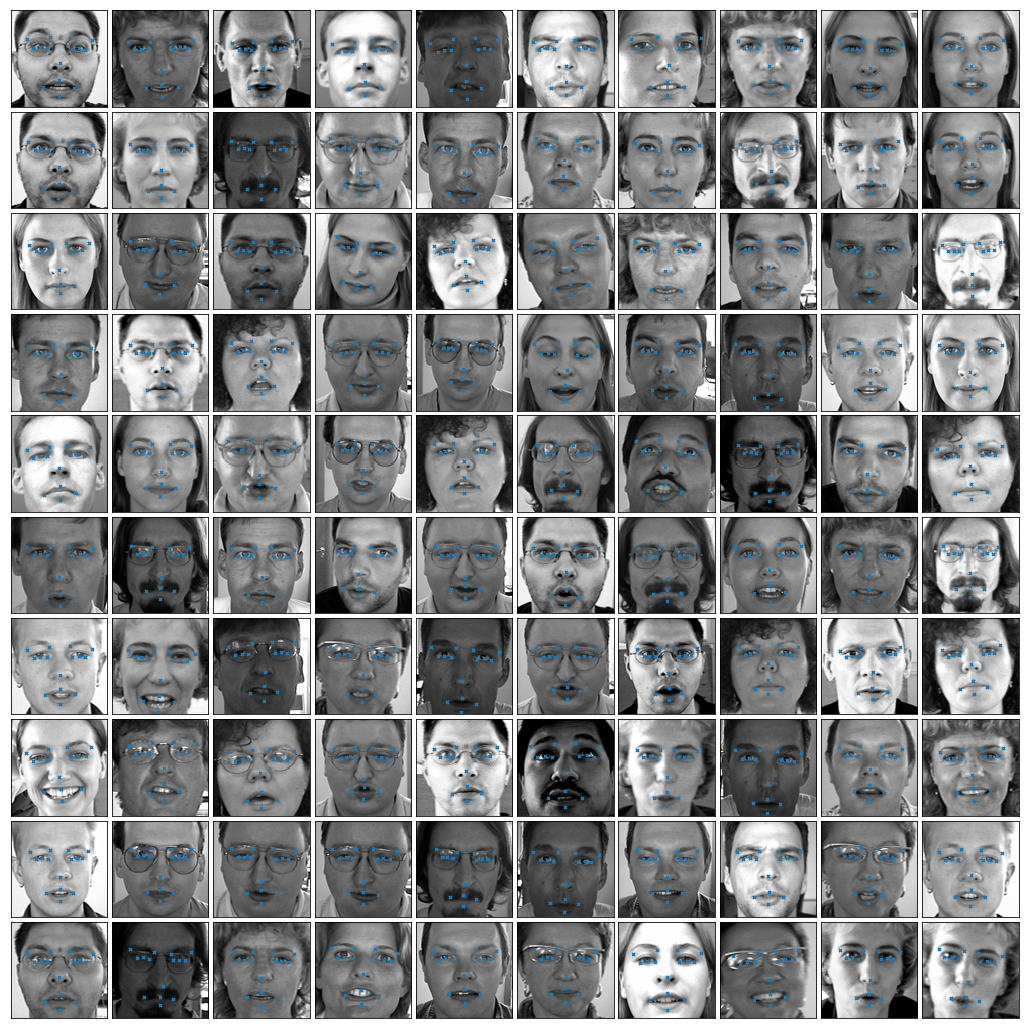

In [124]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X = load2d(test=True)[0]
y_pred = net_dropout.predict(X)

fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[]) # taking 100 test images
    plot_sample(X[i], y_pred[i], ax)

plt.show()

**Conclusion**  

To keep this project simple from the train data of total 7049 images only 2140 images, which have all 15 keypoints have been used. Removing almost 70% of data is probably not the best approach to do the project as this introduces much more biases and problem of overfitting. So this project can surely be enhanced if all the train data used for training.
Convolution Neural Net using Lasagne and Theano is highly used and very popular in the field of Facial Recognition. Though KNN, SVM are also heavily used for image recognition and provide a very competitive result, CNN is used here as a very obvious learning opportunity.